In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [5]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [6]:
atlasAlignParams_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams_atlas'

In [10]:
# T_final = {}

parameters_allStacks_allLandmarks = defaultdict(dict)
atlas_centroid_allStacks_allLandmarks = defaultdict(dict)
test_centroid_allStacks_allLandmarks = defaultdict(dict)

for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):

#     with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#         lines = f.readlines()
#     T_final[stack] = np.array(map(float, lines[1].strip().split()))
    
    for name in labels_sided:

        tf_fn = atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_%(name)s_transformUponAffineProjection.txt' % \
                            {'stack': stack, 'name': name}
        
        if not os.path.exists(tf_fn):
            continue
        
        with open(tf_fn, 'r') as f:
            lines = f.readlines()
            params = np.array(map(float, lines[0].strip().split()))
            atlas_centroid = np.array(map(float, lines[1].strip().split()))
            test_centroid = np.array(map(float, lines[2].strip().split()))

        parameters_allStacks_allLandmarks[stack][name] = params
        atlas_centroid_allStacks_allLandmarks[stack][name] = atlas_centroid
        test_centroid_allStacks_allLandmarks[stack][name] = test_centroid
        
parameters_allStacks_allLandmarks.default_factory = None
atlas_centroid_allStacks_allLandmarks.default_factory = None
test_centroid_allStacks_allLandmarks.default_factory = None

In [11]:
txs_allLandmarks = defaultdict(list)
tys_allLandmarks = defaultdict(list)
tzs_allLandmarks = defaultdict(list)

translations_allStack_allLandmarks = defaultdict(dict)

for stack, lm_tforms in parameters_allStacks_allLandmarks.iteritems():
    for name, T in lm_tforms.iteritems():
        Tm = np.reshape(T, (3,4))
        t = Tm[:, 3]
        R = Tm[:, :3]
        translations_allStack_allLandmarks[stack][name] = t
        
#         txs_allLandmarks[name].append(t[0])
#         tys_allLandmarks[name].append(t[1])
#         tzs_allLandmarks[name].append(t[2])
        
        txs_allLandmarks[name].append(t[0] * xy_pixel_distance_downsampled)
        tys_allLandmarks[name].append(t[1] * xy_pixel_distance_downsampled)
        tzs_allLandmarks[name].append(t[2] * xy_pixel_distance_downsampled)
    
translations_allStack_allLandmarks.default_factory = None

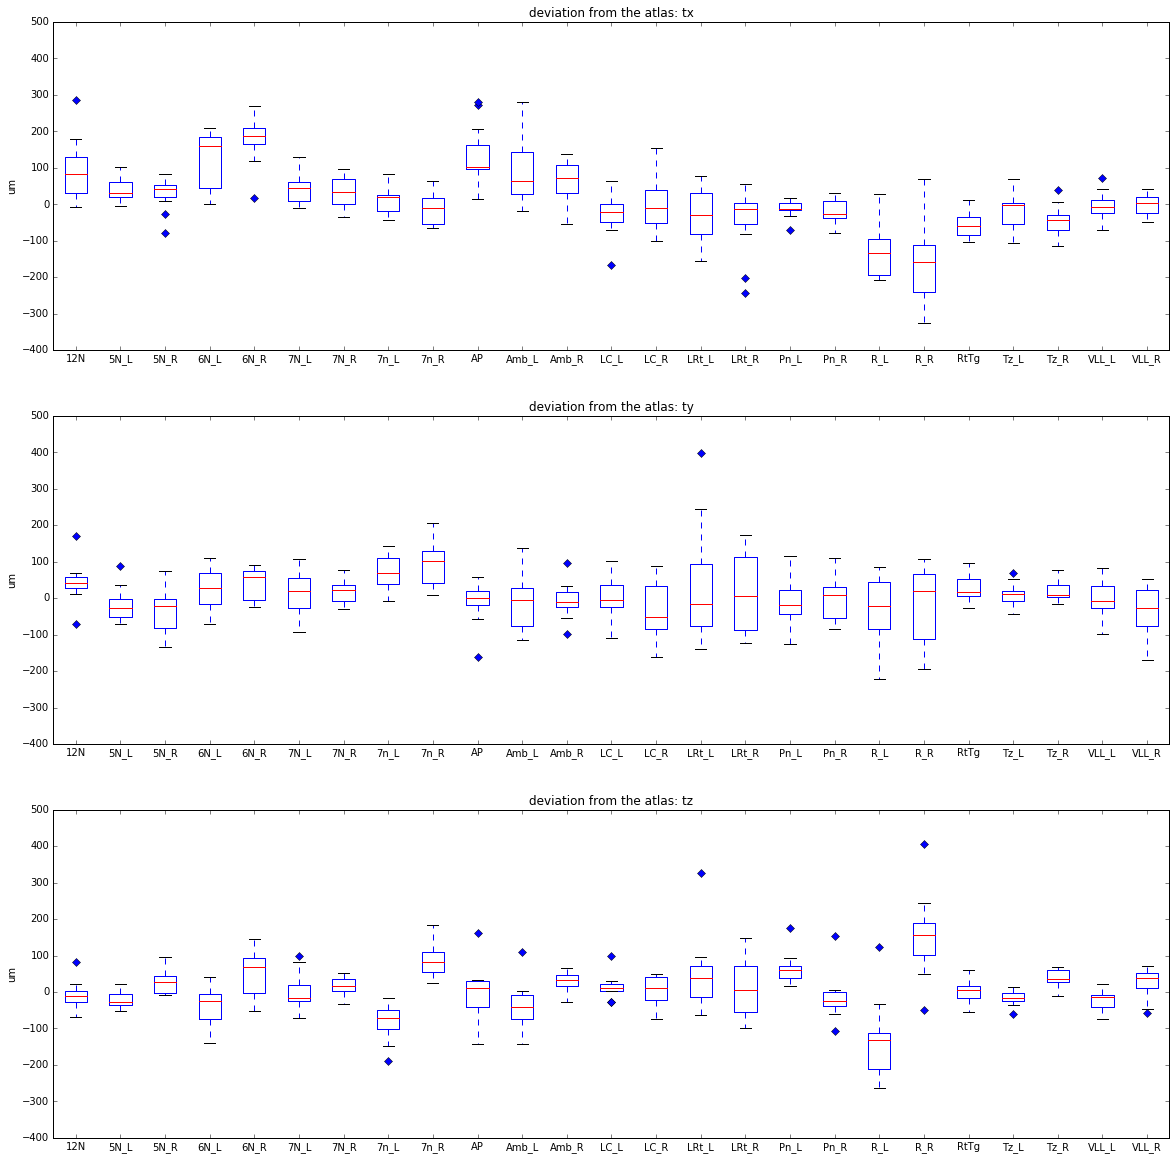

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(20,20), squeeze=True, sharey=True)

for i, (d, v) in enumerate(zip([txs_allLandmarks, tys_allLandmarks, tzs_allLandmarks], ['tx', 'ty', 'tz'])):

    names = sorted(d.keys())
    data = np.array([d[name] for name in names]).T

    axes[i].boxplot(data, 0, 'gD');
#     axes[i].set_xticks(range(data.shape[1]), names);
    axes[i].set_ylabel('um');
    axes[i].set_title('deviation from the atlas: %s' % v)
    
plt.setp(axes, xticks=range(1, 1+data.shape[1]), xticklabels=names)
plt.show();